Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [129]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [2]:
num_classes = 10
np.random.seed(133)

In [3]:
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [3]:
# set variables for resume
rain_folders=['notMNIST_large/A',
 'notMNIST_large/B',
 'notMNIST_large/C',
 'notMNIST_large/D',
 'notMNIST_large/E',
 'notMNIST_large/F',
 'notMNIST_large/G',
 'notMNIST_large/H',
 'notMNIST_large/I',
 'notMNIST_large/J']

test_folders=['notMNIST_small/A',
 'notMNIST_small/B',
 'notMNIST_small/C',
 'notMNIST_small/D',
 'notMNIST_small/E',
 'notMNIST_small/F',
 'notMNIST_small/G',
 'notMNIST_small/H',
 'notMNIST_small/I',
 'notMNIST_small/J']

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

10 10 1 notMNIST_large/A/TWFnbnVzLm90Zg==.png
10 10 2 notMNIST_large/A/T3JreSAxLnR0Zg==.png
10 10 3 notMNIST_large/A/TGVnYWN5U2FuSVRDLUJvb2tJdGFsT1Mub3Rm.png
10 10 4 notMNIST_large/A/TGlmZSBpcyBsaWZlLnR0Zg==.png
10 10 5 notMNIST_large/A/RWRtdW5kcy50dGY=.png
10 10 6 notMNIST_large/A/U0YgU29sYXIgU2FpbGVyIE91dGxpbmUudHRm.png
10 10 7 notMNIST_large/A/Q2FsaXN0b01UU3RkLUJvbGQub3Rm.png
10 10 8 notMNIST_large/A/RW5ncmF2ZXJzTVRTdGQtQm9sZC5vdGY=.png
10 10 9 notMNIST_large/A/TENSIE9uIHRoZSBGYXJtLnR0Zg==.png
10 10 10 notMNIST_large/A/RElZIE9uZS50dGY=.png
10 10 11 notMNIST_large/B/U3RldmVIYW5kLm90Zg==.png
10 10 12 notMNIST_large/B/RnJpZW5kcy1Db25kZW5zZWQgTm9ybWFsLnR0Zg==.png
10 10 13 notMNIST_large/B/TFRVbml2ZXJzLUV4dGRVbHRMdC5vdGY=.png
10 10 14 notMNIST_large/B/S29zbWlrLUdseXBocy5vdGY=.png
10 10 15 notMNIST_large/B/QWx0ZW11c0NoZWNrcy5vdGY=.png
10 10 16 notMNIST_large/B/c3BhcnJvdyAoc1JCKS50dGY=.png
10 10 17 notMNIST_large/B/QmlvbmljIFR5cGUgT3V0IEl0YWxpYy50dGY=.png
10 10 18 notMNIST_large/B/QXJiaXRy

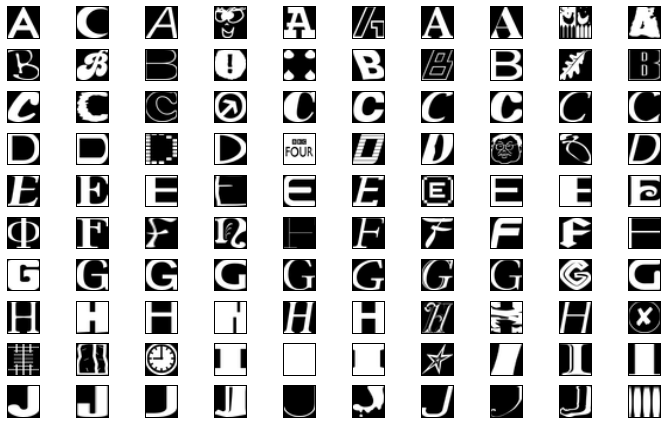

In [212]:
plt.figure(figsize=(10, 6), dpi=80)
pixel_depth = 255.0  # Number of levels per pixel.

folders = train_folders
num_r = len(folders)
num_c = 10
images = []
for r in range(num_r):
    folder = folders[r]
    image_files = os.listdir(folder)
    num_files = len(image_files)
    file_indexes = np.random.randint(0, num_files, num_c)
    for c in range(num_c):
        file_index = file_indexes[c]
        file_name = os.path.join(folder, image_files[file_index])

        print(num_r, num_c, r * num_c + c + 1, file_name)
        plt.subplot(num_r, num_c, r * num_c + c + 1)
        image = ndimage.imread(file_name).astype(float)
        plt.imshow(image, cmap="gray", vmin=0.0, vmax=pixel_depth)
        plt.xticks(())
        plt.yticks(())
        images.append(image)
plt.tight_layout()
plt.show()

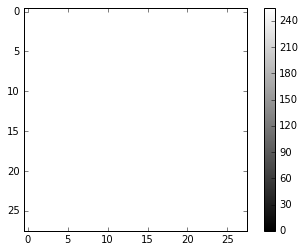

In [213]:
# check almost white image

#file_name = "notMNIST_large/I/UmFkaWFudEVGRGlzcGxheS1Db25kTm81Lm90Zg==.png"
#image = ndimage.imread(file_name).astype(float)
image_number = 85
image = images[image_number - 1]
plt.imshow(image, cmap="gray", vmin=0.0, vmax=pixel_depth)
plt.colorbar()

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [35]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

In [5]:
def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.44312
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.454491
Pickling notMNIST_large/C.pick

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [51]:
# set variables for resume
train_datasets = list(map(lambda folder:folder + '.pickle', train_folders))
test_datasets = list(map(lambda folder:folder + '.pickle', test_folders))

10 10 1 notMNIST_large/A.pickle 5417
10 10 2 notMNIST_large/A.pickle 27309
10 10 3 notMNIST_large/A.pickle 17945
10 10 4 notMNIST_large/A.pickle 51790
10 10 5 notMNIST_large/A.pickle 47477
10 10 6 notMNIST_large/A.pickle 11989
10 10 7 notMNIST_large/A.pickle 33279
10 10 8 notMNIST_large/A.pickle 22092
10 10 9 notMNIST_large/A.pickle 26928
10 10 10 notMNIST_large/A.pickle 26652
10 10 11 notMNIST_large/B.pickle 11713
10 10 12 notMNIST_large/B.pickle 6926
10 10 13 notMNIST_large/B.pickle 7199
10 10 14 notMNIST_large/B.pickle 12317
10 10 15 notMNIST_large/B.pickle 8397
10 10 16 notMNIST_large/B.pickle 14089
10 10 17 notMNIST_large/B.pickle 41540
10 10 18 notMNIST_large/B.pickle 8493
10 10 19 notMNIST_large/B.pickle 30082
10 10 20 notMNIST_large/B.pickle 41999
10 10 21 notMNIST_large/C.pickle 6871
10 10 22 notMNIST_large/C.pickle 4497
10 10 23 notMNIST_large/C.pickle 37035
10 10 24 notMNIST_large/C.pickle 29577
10 10 25 notMNIST_large/C.pickle 52750
10 10 26 notMNIST_large/C.pickle 37514
10

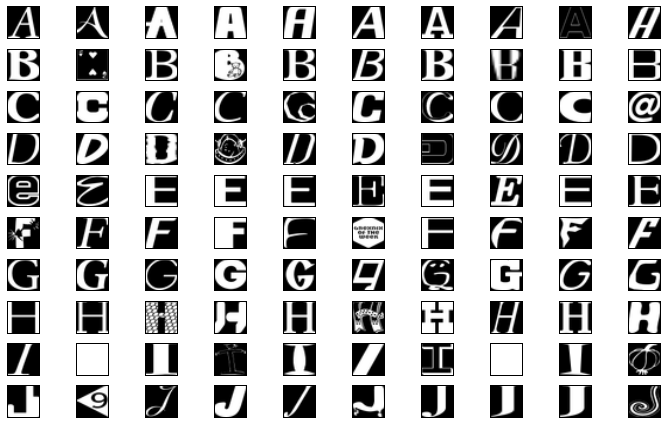

In [214]:
plt.figure(figsize=(10, 6), dpi=80)
vmin = -0.5
vmax = +0.5

datasets = train_datasets
num_r = len(datasets)
num_c = 10
images = []
for r in range(num_r):
    set_filename = datasets[r] 
    with open(set_filename, 'rb') as f:
        dataset = pickle.load(f)
    num_images = len(dataset)
    image_indexes = np.random.randint(0, num_images, num_c)
    for c in range(num_c):
        image_index = image_indexes[c]
        image = dataset[image_index]
        print(num_r, num_c, r * num_c + c + 1, set_filename, image_index)
        plt.subplot(num_r, num_c, r * num_c + c + 1)
        plt.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
        images.append(image)
plt.tight_layout()
plt.show()

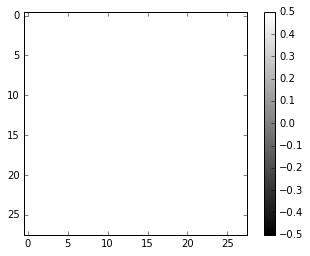

In [215]:
# check almost white image

image_number = 82
image = images[image_number - 1]
plt.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
plt.colorbar()

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [53]:
datasets = train_datasets
num_r = len(datasets)
for r in range(num_r):
    set_filename = datasets[r] 
    with open(set_filename, 'rb') as f:
        dataset = pickle.load(f)
    num_images = len(dataset)
    print(set_filename, ": ", num_images, " images")

notMNIST_large/A.pickle :  52909  images
notMNIST_large/B.pickle :  52911  images
notMNIST_large/C.pickle :  52912  images
notMNIST_large/D.pickle :  52911  images
notMNIST_large/E.pickle :  52912  images
notMNIST_large/F.pickle :  52912  images
notMNIST_large/G.pickle :  52912  images
notMNIST_large/H.pickle :  52912  images
notMNIST_large/I.pickle :  52912  images
notMNIST_large/J.pickle :  52911  images


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [6]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [7]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [54]:
# set variables for resume
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)

3 10 1 train_dataset 6506
3 10 2 train_dataset 15433
3 10 3 train_dataset 7746
3 10 4 train_dataset 154481
3 10 5 train_dataset 66171
3 10 6 train_dataset 44288
3 10 7 train_dataset 30194
3 10 8 train_dataset 75342
3 10 9 train_dataset 96538
3 10 10 train_dataset 34263
3 10 11 valid_dataset 2693
3 10 12 valid_dataset 8399
3 10 13 valid_dataset 7376
3 10 14 valid_dataset 650
3 10 15 valid_dataset 2266
3 10 16 valid_dataset 1045
3 10 17 valid_dataset 7098
3 10 18 valid_dataset 7840
3 10 19 valid_dataset 1785
3 10 20 valid_dataset 3634
3 10 21 test_dataset 9772
3 10 22 test_dataset 1985
3 10 23 test_dataset 2795
3 10 24 test_dataset 9297
3 10 25 test_dataset 1758
3 10 26 test_dataset 5
3 10 27 test_dataset 7094
3 10 28 test_dataset 3632
3 10 29 test_dataset 2860
3 10 30 test_dataset 3900


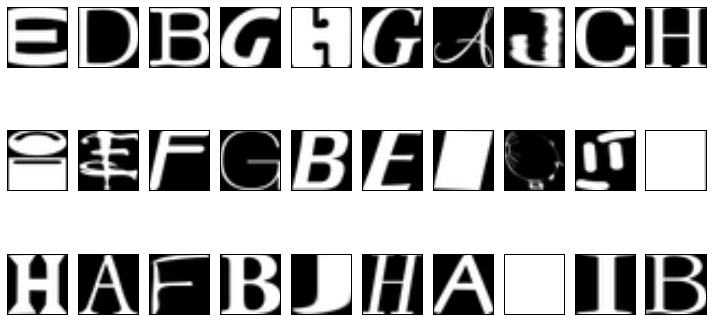

In [216]:
plt.figure(figsize=(10, 6), dpi=80)

datasets = ['train_dataset', 'valid_dataset', 'test_dataset']
num_r = len(datasets)
num_c = 10
images = []
for r in range(num_r):
    set_name = datasets[r] 
    dataset = save[set_name]
    num_images = len(dataset)
    image_indexes = np.random.randint(0, num_images, num_c)
    for c in range(num_c):
        image_index = image_indexes[c]
        image = dataset[image_index]
        print(num_r, num_c, r * num_c + c + 1, set_name, image_index)
        plt.subplot(num_r, num_c, r * num_c + c + 1)
        plt.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
        images.append(image)
plt.tight_layout()
plt.show()

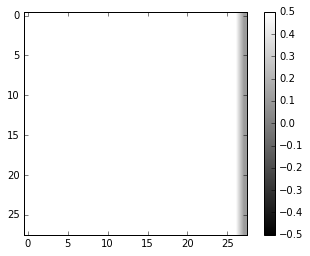

In [217]:
# check almost white image

image_number = 20
image = images[image_number - 1]
plt.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
plt.colorbar()

Finally, let's save the data for later reuse:

In [8]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [9]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

Number of almost white image in train_dataset: 2713/200000 = 1.357%
Number of almost white image in valid_dataset: 159/10000 = 1.590%
Number of almost white image in test_dataset: 175/10000 = 1.750%


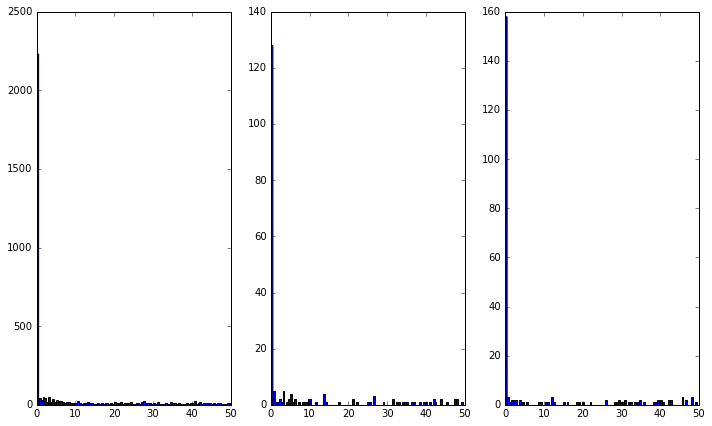

In [283]:
# check almost white images at first
datasets = ['train_dataset', 'valid_dataset', 'test_dataset']

plt.figure(figsize=(10, 6), dpi=80)

threshold = 10.0
threshold2 = 5.0

threshold3 = 50
num_bins = 100

images = []
n = 0
for set_name in datasets:
    errs = []
    dataset = save[set_name]
    num_white = 0
    for i in range(len(dataset)):
        image = dataset[i]
        err = np.sum((image - 0.5) ** 2)
        if err <= threshold3:
            errs.append(err)
        if err <= threshold:
#            print("{}[{}] is almost white: err={:.3f}".format(set_name, i, err)) 
            num_white += 1
            if err >= threshold2:
                images.append(image)
    print("Number of almost white image in {}: {}/{} = {:.3f}%".format(
            set_name, num_white, len(dataset), 100.0 * num_white / len(dataset)))
    n += 1
    plt.subplot(1, 3, n)
    plt.hist(errs, bins = num_bins)
    
plt.tight_layout()
plt.show()

196


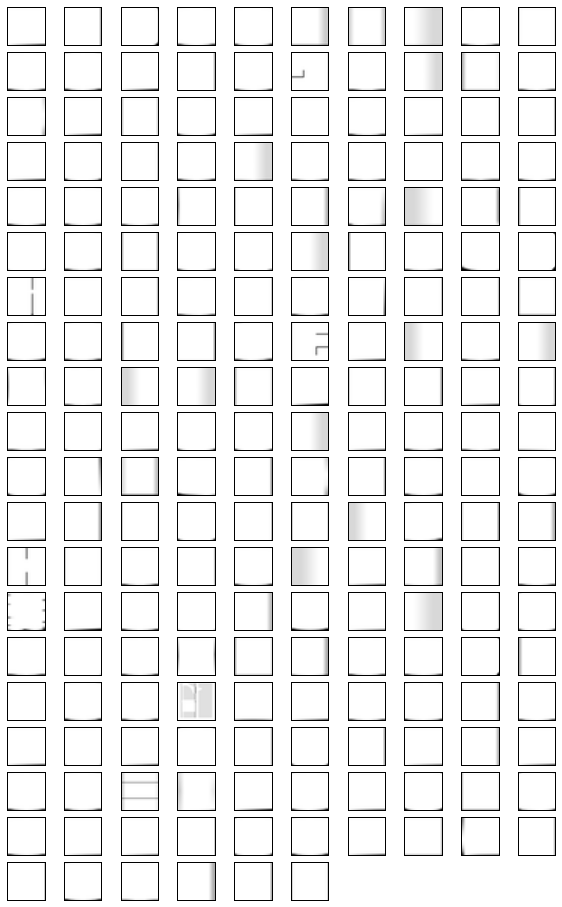

In [284]:
# check almost white images

plt.figure(figsize=(10, 16), dpi=80)

def show_images(images, num_r, num_c):
    for r in range(num_r):
        for c in range(num_c):
            i = r * num_c + c
            if i >= len(images):
                return
            image = images[i]
            plt.subplot(num_r, num_c, r * num_c + c + 1)
            plt.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
            plt.xticks(())
            plt.yticks(())
    plt.tight_layout()
    plt.show()
print(len(images))
show_images(images, 20, 10)

0.0


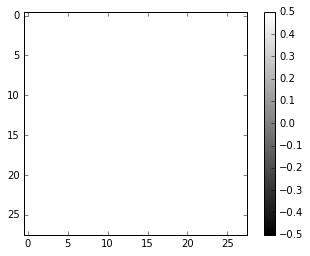

In [232]:
# check almost white image

train_dataset = save['train_dataset']
image = train_dataset[128]
plt.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=1.0)

err = np.sum((image - 0.5) ** 2)
print(err)

In [331]:
datasets = ['train_dataset', 'valid_dataset', 'test_dataset']

def get_errs(dataset):
    errs = np.zeros(len(dataset))
    for i in range(len(dataset)):
        image = dataset[i]
        err = np.sum((image - 0.5) ** 2)
        errs[i] = err
    return errs

def dup_check(set_index1, set_index2, cutoff=0):
    global near_images1, near_images2, near_errs
    near_images1 = []
    near_images2 = []
    near_errs    = []
    
    set_name1 = datasets[set_index1]
    set_name2 = datasets[set_index2]
    dataset1 = save[set_name1]
    dataset2 = save[set_name2]
    
    # for debug
    if cutoff != 0:
        dataset1 = dataset1[:cutoff]
        dataset2 = dataset2[:cutoff]

    errs1 = get_errs(dataset1)
    errs2 = get_errs(dataset2)

    num_white = 0
    num_equal = 0
    num_near  = 0
    num_cmp   = 0
    for i1 in range(len(dataset1)):
#    for i1 in range(0, 129):
        image1 = dataset1[i1]
        err1 = errs1[i1]
        if err1 <= threshold:
            num_white += 1
            continue # skip almost white image
        for i2 in range(len(dataset2)):
#        for i2 in range(178, 332):
            err2 = errs2[i2]
            if abs((err1 - err2)) >= threshold4:
                continue # skip 
            image2 = dataset2[i2]
            err = np.sum((image1 - image2) ** 2)
            num_cmp += 1
            if num_cmp % 100000 == 0:
                print("i1={}, i2={}, white={}, equal={}, near={}, total={} ".format(
                        i1, i2, num_white, num_equal, num_near, num_white+num_equal+num_near))
            if err <= threshold:
#                print("err between {}[{}] and {}[{}] = {:.3f}".format(set_name1, i1, set_name2, i2, err))
                if err == 0.0:
                    num_equal += 1
                else:
                    num_near += 1
                    if err >= threshold2:
                        near_images1.append(image1)
                        near_images2.append(image2)
                        near_errs.append(err)
                break # skip remaining data
    print("dup_check({}, {}): white={}, equal={}, near={}, total={} (threshold = {:.3f})".format(
            set_name1, set_name2, num_white, num_equal, num_near, 
            num_white+num_equal+num_near,threshold))

threshold = 1.0
threshold2 = 0.5
threshold4 = threshold * 1.1 # 1.0 might be enough?

dup_check(1, 0, cutoff=4000)
dup_check(2, 0, cutoff=4000)


dup_check(valid_dataset, train_dataset): white=0, equal=0, near=0, total=0 (threshold = 1.000)
dup_check(test_dataset, train_dataset): white=0, equal=0, near=0, total=0 (threshold = 1.000)


In [299]:
datasets = ['train_dataset', 'valid_dataset', 'test_dataset']
labelses   = ['train_labels', 'valid_labels', 'test_labels']

threshold = 1.0
threshold2 = 0.5
threshold4 = threshold * 1.1 # 1.0 might be enough?

def get_errs(dataset):
    errs = np.zeros(len(dataset))
    for i in range(len(dataset)):
        image = dataset[i]
        err = np.sum((image - 0.5) ** 2)
        errs[i] = err
    return errs

def sanitize(set_index1, set_index2, cutoff=0):):
    set_name1 = datasets[set_index1]
    dataset1 = save[set_name1]

    label_name1 = labelses[set_index1]
    labels = save[label_name1]

    set_name2 = datasets[set_index2]
    dataset2 = save[set_name2]

    # for debug
    if cutoff != 0:
        dataset1 = dataset1[:cutoff]
        labels = labels[:cutoff]
        dataset2 = dataset2[:cutoff]

    mask1 = np.ones(len(dataset1), dtype='bool')

    errs1 = get_errs(dataset1)
    errs2 = get_errs(dataset2)

    num_white = 0
    num_equal = 0
    num_near  = 0
    num_cmp   = 0
    for i1 in range(len(dataset1)):
#    for i1 in range(0, 129):
        image1 = dataset1[i1]
        err1 = errs1[i1]
        if err1 <= threshold:
            mask1[i1] = False
            num_white += 1
            continue # skip almost white image
        for i2 in range(len(dataset2)):
#        for i2 in range(178, 332):
            err2 = errs2[i2]
            if abs((err1 - err2)) >= threshold4:
                continue # skip 
            image2 = dataset2[i2]
            err = np.sum((image1 - image2) ** 2)
            num_cmp += 1
            if num_cmp % 100000 == 0:
                print("i1={}, i2={}, white={}, equal={}, near={}, total={} ".format(
                        i1, i2, num_white, num_equal, num_near, num_white+num_equal+num_near))
            if err <= threshold:
                mask1[i1] = False
#                print("err between {}[{}] and {}[{}] = {:.3f}".format(set_name1, i1, set_name2, i2, err))
                if err == 0.0:
                    num_equal += 1
                else:
                    num_near += 1
                break # skip remaining data
    print("sanitize({}, {}): white={}, equal={}, near={}, total={} (threshold = {:.3f})".format(
            set_name1, set_name2, num_white, num_equal, num_near, 
            num_white+num_equal+num_near,threshold))
    return dataset1[mask1], labels[mask1]

valid_dataset, valid_labels = sanitize(1, 0)
test_dataset, test_labels = sanitize(2, 0)
print(len(valid_dataset), len(valid_labels))
print(len(test_dataset), len(test_labels))

i1=111, i2=15471, num_equal=6, num_near=5
i1=220, i2=154458, num_equal=12, num_near=6
i1=342, i2=15294, num_equal=20, num_near=13
i1=467, i2=65194, num_equal=28, num_near=22
i1=588, i2=167824, num_equal=40, num_near=26
i1=710, i2=7417, num_equal=51, num_near=31
i1=835, i2=142129, num_equal=65, num_near=38
i1=952, i2=189853, num_equal=74, num_near=43
i1=1083, i2=85686, num_equal=91, num_near=55
i1=1205, i2=151308, num_equal=103, num_near=62
i1=1320, i2=192654, num_equal=110, num_near=68
i1=1438, i2=58323, num_equal=124, num_near=72
i1=1562, i2=23608, num_equal=138, num_near=77
i1=1687, i2=29087, num_equal=151, num_near=81
i1=1811, i2=7802, num_equal=165, num_near=87
i1=1937, i2=20930, num_equal=173, num_near=99
i1=2059, i2=25940, num_equal=184, num_near=110
i1=2175, i2=152711, num_equal=194, num_near=121
i1=2293, i2=63474, num_equal=208, num_near=125
i1=2410, i2=147235, num_equal=219, num_near=130
i1=2526, i2=161933, num_equal=231, num_near=135
i1=2654, i2=3187, num_equal=244, num_near=

In [301]:
# write sanitized data to file
pickle_file = 'notMNIST-sanitized.pickle'

save['valid_dataset'] = valid_dataset
save['valid_labels'] = valid_labels
save['test_dataset'] = test_dataset
save['test_labels'] = test_labels

try:
  f = open(pickle_file, 'wb')
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 680237552


In [337]:
# check sanitized data
threshold  = 5.0
threshold2 = 2.0
threshold4 = threshold * 1.1 # 1.0 might be enough?

dup_check(1, 0, cutoff=4000)
print(len(near_images1))
#dup_check(2, 0, cutoff=4000)

i1=1094, i2=2566, white=0, equal=0, near=14, total=14 
i1=2201, i2=2262, white=0, equal=0, near=29, total=29 
i1=3280, i2=2672, white=0, equal=0, near=43, total=43 
dup_check(valid_dataset, train_dataset): white=0, equal=0, near=54, total=54 (threshold = 5.000)
39


[3.3841753, 3.5006533, 2.493072, 4.7639985, 4.5714111, 4.3757939]


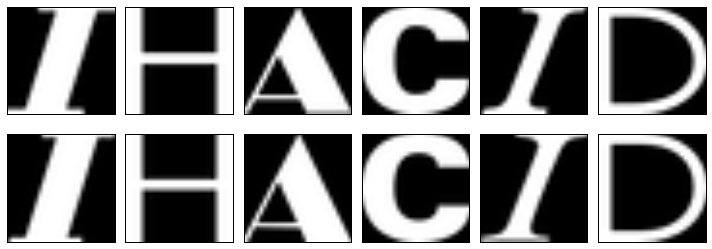

In [341]:
# check near images

plt.figure(figsize=(10, 4), dpi=80)
index = 12
num_c = 6
near_images1cut = near_images1[index:index+num_c]
near_images2cut = near_images2[index:index+num_c]
near_errscut    = near_errs[index:index+num_c]

def show_near_images(images, num_r, num_c, r):
    for i in range(len(images)):
        image = images[i]
        plt.subplot(num_r, num_c, r * num_c + i + 1)
        plt.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
        plt.xticks(())
        plt.yticks(())

print(near_errscut)
show_near_images(near_images1cut, 2, num_c, 0)
show_near_images(near_images2cut, 2, num_c, 1)

plt.tight_layout()
plt.show()



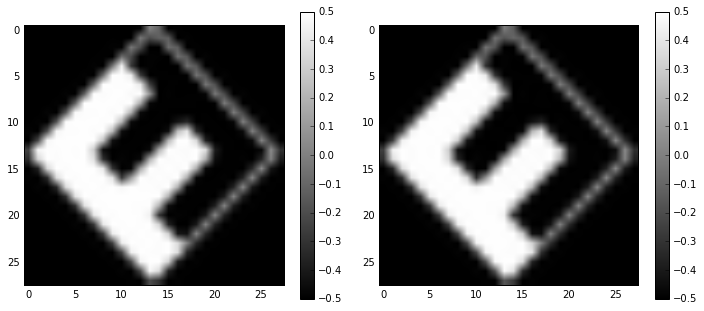

0.129596


In [249]:
# test two images as sample

plt.figure(figsize=(10, 6), dpi=80)

datasets = ['train_dataset', 'valid_dataset', 'test_dataset']
set_index1 = 0
set_index2 = 1
#i1 = 33
#i2 = 177
i1 = 383
i2 = 9244

set_name1 = datasets[set_index1]
set_name2 = datasets[set_index2]
dataset1 = save[set_name1]
dataset2 = save[set_name2]
image1 = dataset1[i1]
image2 = dataset2[i2]
plt.subplot(1,2,1)
plt.imshow(image1, cmap="gray", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=.70)
plt.subplot(1,2,2)
plt.imshow(image2, cmap="gray", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=.70)

plt.tight_layout()
plt.show()

diff = image1 - image2
print(np.sum(diff * diff))

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---